# Programando el Algoritmo de Naive-Bayes

**Resumen General**
Este Notebook se centra en la construcción, desarrollo e implementación de un modelo de aprendizaje automático utilizando el método de clasificación Naive-Bayes para el diagnóstico del cáncer utilizando un data frame con información de bultos cancerosos encontrados en pacientes analizados. A través de un enfoque práctico y detallado, el cuaderno guía a los alumnos en el proceso de desarrollo de un modelo predictivo, desde la carga y exploración de datos hasta la evaluación del modelo.

 En esta práctica, Vamos a **construir un método de clasificación de Naive-Bayes desde 0, sin utilizar la librería de sk-learn** para generar el modelo. Nos enfrentaremos a un data set de características numéricas y veremos dos maneras diferenciadas de abordar esta problemática.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")



## 1 Analisis Exploratorio y procesamiento de los datos

A nivel mundial, el cáncer de mama es el tipo de cáncer más común en mujeres y el segundo con las tasas de mortalidad más altas. El diagnóstico del cáncer de mama se realiza cuando se encuentra un bulto anormal (ya sea mediante autoexamen o radiografía) o se observa una pequeña partícula de calcio (en una radiografía). Después de encontrar un bulto sospechoso, el médico llevará a cabo un diagnóstico para determinar si es canceroso y, en ese caso, si se ha propagado a otras partes del cuerpo.

Este conjunto de datos sobre el cáncer de mama se obtuvo de la Universidad de Wisconsin Hospitals, Madison, del Dr. William H. Wolberg.

In [ ]:
# Conexión con drive para obtener el .csv
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data = pd.read_csv("/home/marco/Clasificaciones y agrupaciones/Naive Bayes/Breast_cancer_data.csv",)
data.head(10)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
5,12.45,15.70,82.57,477.1,0.12780,0
6,18.25,19.98,119.60,1040.0,0.09463,0
7,13.71,20.83,90.20,577.9,0.11890,0
8,13.00,21.82,87.50,519.8,0.12730,0
9,12.46,24.04,83.97,475.9,0.11860,0


Vemos que las características son todo variables continuas. Cómo vimos en la teoría, el método de Naive-Bayes funciona peor ante variables numéricas continuas. Ante esta situación, tenemos dos posibbles soluciones que pondremos en práctia:

1. Suponer que las vairables siguen una distribución normal (gaussiana) y aplicar un Navie-Bayes Gaussiano.

2. Convertir las variables continuas en categóricas y aplicar un modelo de Naive-Bayes multinomial.



Analizamos la distribución de la variable objetivo. Observamos que el dataset está un poco desbalanceado.

<Axes: >

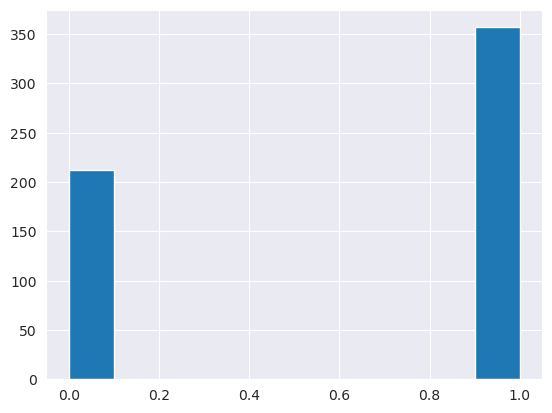

In [3]:
data["diagnosis"].hist()

Como hemos estudiado en la parte teórica, el método Naive-Bayes supone independencia entre las características. Para ver si nuestros datos cumplen esta suposición, vamos a representar la matriz de correlaciones:

<Axes: >

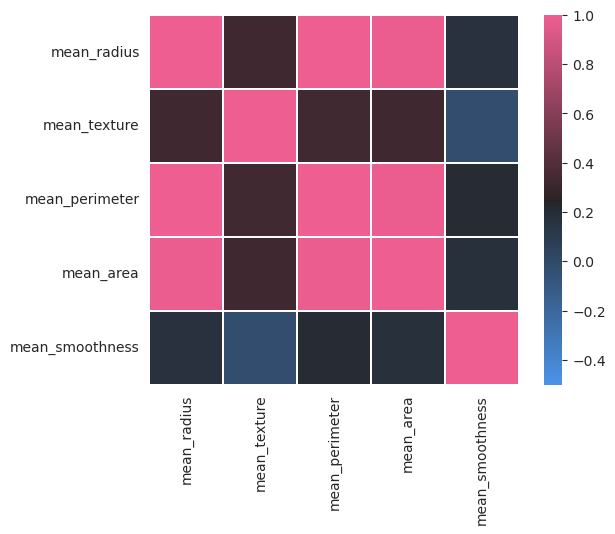

In [4]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

Podemos observar que existen tres variables muy correlacionadas entre ellas: el radio, el perímetro y el área, lo cual tiene sentido. Seleccionamos únicamente una de las tres (el radio en este caso) junto con la textura y la suavidad para cumplir las hipótesis de independencia.

Uno de los principios más importantes en la modelización es la **parsimonia**. Este concepto fundamental se basa en la idea de que un modelo debe ser tan simple como sea posible, sin dejar de ser lo suficientemente complejo para explicar los datos y cumplir con los objetivos del análisis. Esto implica implica que un modelo debe lograr un equilibrio óptimo entre complejidad y capacidad explicativa.

En nuestro caso, tenemos 3 variables altamente correlacionadas que nos explican la misma variabilidad sobre la respuesta, por lo que es mejor quedarse con una única para tener un modelo más simple y óptimo.


**Ejercicio Adicional:** Realiza los modelos con todas las variables, sin cumplirse así las impótesis de independencia y evalúa el modelo para ver cómo empeora la clasificación

In [5]:
data = data[["mean_radius", "mean_texture", "mean_smoothness", "diagnosis"]]
data.head(10)

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
5,12.45,15.70,0.12780,0
6,18.25,19.98,0.09463,0
7,13.71,20.83,0.11890,0
8,13.00,21.82,0.12730,0
9,12.46,24.04,0.11860,0


## 2 Modelización asumiendo Naive-Bayes Gaussiano

Primeramente optaremos por asumir una distribución normal para las características de nuestro data set y aplicaremos un N-B Gaussiano. Vamos a estudiar si las variables pueden encajar en dicha distribución.

<Axes: xlabel='mean_texture', ylabel='Count'>

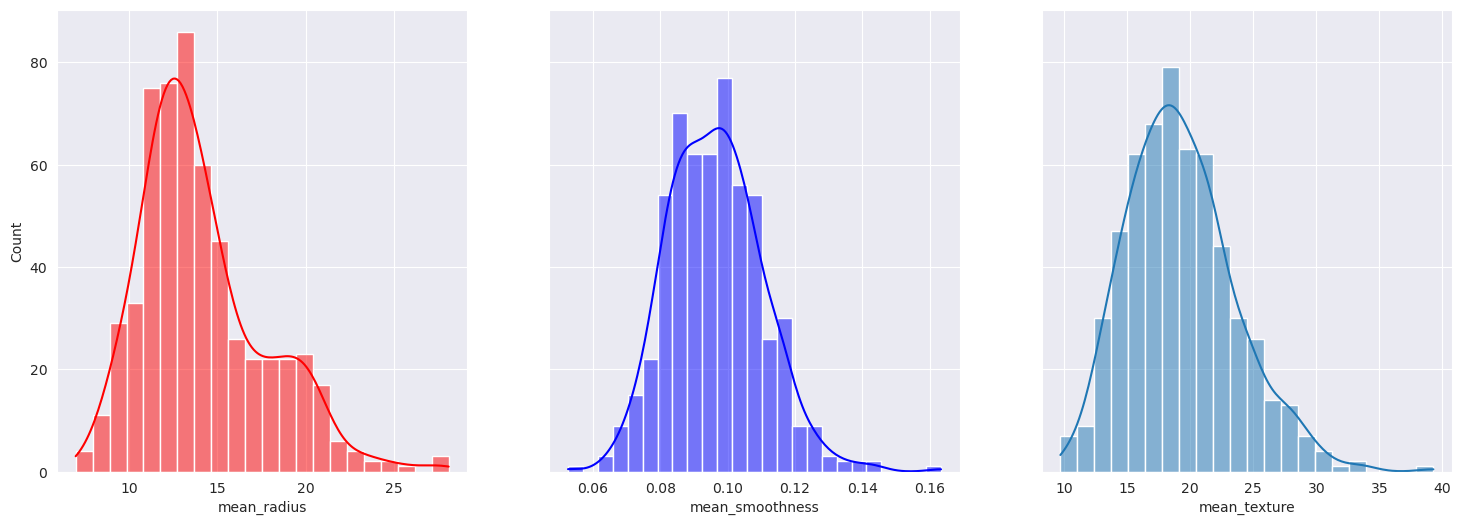

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="mean_radius", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="mean_smoothness", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="mean_texture", kde=True)


Observando las gráficas de densidad de las variables podemos asumir que siguen una distribución normal.

### 2.1 Definición de funciones para la construcción del modelo

Definimos una función para calcular la distribución a priori de las clases, únicamente utilizando el número de observaciones que tenemos de una clase y otra respectivamente en nuestro dataset.

In [7]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
      #dividimos el número de observaciones para una clase por el total de observaciones.
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

Definimos una función de verosimilitud para las características

In [8]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

Habiendo definido ya las funciones para la verosimilitud y para la distribución a priori, únicamente necesitamos una función que calcule la distribución a priori y nos clasifique con el criterio definido en Naive-Bayes.

In [9]:
def naive_bayes_gaussian(df, X, Y):
    # sacamos los nombres de las características
    features = list(df.columns)[:-1]

    # Calculamos la distribución a priori de las clases
    prior = calculate_prior(df, Y)

    #Definimos un array vacío para guardar las predicciones
    Y_pred = []
    # Bucle sobre todas las observaciones de nuestros datos
    for x in X:
        # Calculamos la verosimilitud
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        #pasamos por cada clase
        for j in range(len(labels)):
          #pasamos por cada característica
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # Calculamos la distribución a posteriori (sólo el denominador)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        #Seleccionamos la clase con mayor probabilidad a posteriori
        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

### 2.2 Entrenamiento y evaluación del modelo

Utilizamos la librería sk-learn para dividir nuestro data set entre conjunto de entramiento y de testeo.

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
#Importante sólo testear con nuestro conjunto de entrenamiento
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[36  4]
 [ 0 74]]
0.9736842105263158


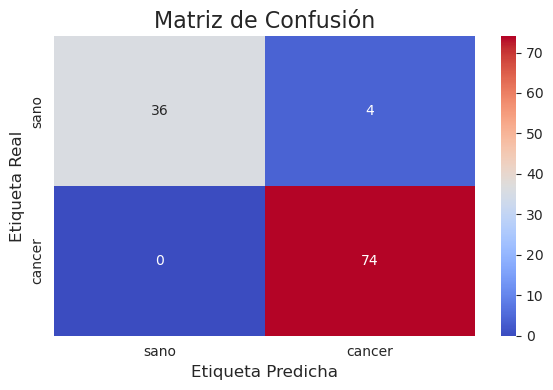

In [11]:
# Generar la matriz de confusión
cm = confusion_matrix(Y_test, Y_pred)

# Etiquetas personalizadas
class_names = ["sano", "cancer"]

# Crear un heatmap con seaborn
plt.figure(figsize=(6, 4))
ax = sns.heatmap(
    cm,
    annot=True,             # Mostrar valores dentro de las celdas
    fmt="d",                # Mostrar números enteros
    cmap="coolwarm",        # Paleta de colores
    xticklabels=class_names,  # Etiquetas personalizadas para el eje X
    yticklabels=class_names   # Etiquetas personalizadas para el eje Y
)

# Agregar títulos y etiquetas
ax.set_title("Matriz de Confusión", fontsize=16)
ax.set_xlabel("Etiqueta Predicha", fontsize=12)
ax.set_ylabel("Etiqueta Real", fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [12]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        40
           1       0.95      1.00      0.97        74

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



En cuánto a la evaluación del modelo NB Gaussiano, vemos que cuenta con una muy buen recall, lo cuál es deseable, para evitar los falsos negativos.

## 3 Modelización asumiendo Naive-Bayes Multinomial

### 3.1 Categorización de características continuas

Ahora vamos a convertir las características en categóricas mediante la función de pandas cut. Las separamos en tres niveles (Se pueden seleccionar más categorías, pero para este ejemplo utilizaremos 3 en todas) cada una y la función nos divide las variables por percentiles de igual tamaño.

In [13]:
data["cat_mean_radius"] = pd.cut(data["mean_radius"].values, bins = 3, labels = [0,1,2])
data["cat_mean_texture"] = pd.cut(data["mean_texture"].values, bins = 3, labels = [0,1,2])
data["cat_mean_smoothness"] = pd.cut(data["mean_smoothness"].values, bins = 3, labels = [0,1,2])

data = data.drop(columns=["mean_radius", "mean_texture", "mean_smoothness"])
data = data[["cat_mean_radius",	"cat_mean_texture",	"cat_mean_smoothness", "diagnosis"]]
data.head(10)

,cat_mean_radius,cat_mean_texture,cat_mean_smoothness,diagnosis
0,1,0,1,0
1,1,0,0,0
2,1,1,1,0
3,0,1,2,0
4,1,0,1,0
5,0,0,2,0
6,1,1,1,0
7,0,1,1,0
8,0,1,2,0
9,0,1,1,0


**Ejercicio adicional**. Estudia detenidamente la distribución de valores de las variables numéricas y determina una mejor discretización para ellas. ¿Afecta esto a la capacidad de clasificación de nuestro modelo? ¿Obtenemos un modelo resultante mejor o peor?

### 3.2 Definición de funciones para la construcción del modelo

Al ser variables categóricas, para la verosimilitud únicamente contamos las frecuencias de cada característica dada una clase

In [14]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

La función para el cálculo de la distribución a priori definida en el apartado anterior nos sirve también para este caso. Así pues, tenemos que construir la función para el N-B Multinomial

In [15]:
def naive_bayes_categorical(df, X, Y):
    # Sacamos los nombres de las características
    features = list(df.columns)[:-1]

    # Calculamos las probabilidades a priori
    prior = calculate_prior(df, Y)

    Y_pred = []
    # Bucle sobre toda la muestra de datos
    for x in X:
        # Calculamos verosimilitud
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

### 3.3 Entrenamiento y evaluación del modelo

De manera análoga al apartado anterior, separamos nuestro data set en conjuntos de prueba y entrenamiento, entrenamos el modelo y evaluamos su habilidad para clasificar.

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[38  2]
 [ 5 69]]
0.9517241379310345


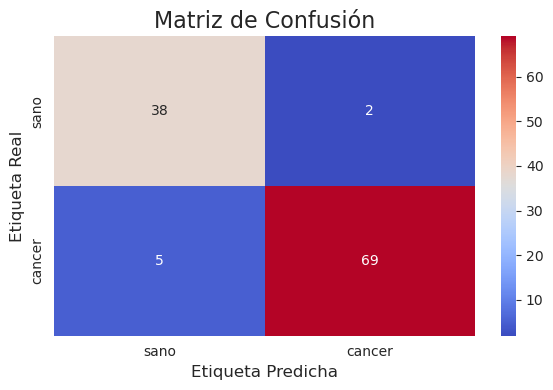

In [17]:
# Generar la matriz de confusión
cm = confusion_matrix(Y_test, Y_pred)

# Etiquetas personalizadas
class_names = ["sano", "cancer"]

# Crear un heatmap con seaborn
plt.figure(figsize=(6, 4))
ax = sns.heatmap(
    cm,
    annot=True,             # Mostrar valores dentro de las celdas
    fmt="d",                # Mostrar números enteros
    cmap="coolwarm",        # Paleta de colores
    xticklabels=class_names,  # Etiquetas personalizadas para el eje X
    yticklabels=class_names   # Etiquetas personalizadas para el eje Y
)

# Agregar títulos y etiquetas
ax.set_title("Matriz de Confusión", fontsize=16)
ax.set_xlabel("Etiqueta Predicha", fontsize=12)
ax.set_ylabel("Etiqueta Real", fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Tenemos un score para este modelo ligeramente inferior al anterior. Esto se debe a que la categorización de variables no se hizo de la forma óptima, eligiendo tres niveles para todas las variables. Para conseguir un mejor modelo, habría que estudiar en detalle las variables y ver qué categorización es la más óptima.

In [18]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92        40
           1       0.97      0.93      0.95        74

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



Como hemos visto en el score, este modelo es ligeramente menos preciso que el anterior, ya que tiene menos accuracy.

Asimismo, el modelo cuenta con un valor de sensibilidad menor, lo que hace que tenga más falsos negativos que en modelo anterior. Esto no nos interesa, ya que se trataría de pacientes con cáncer que no detectamos en nuestro anñalisis. En consecuencia, nos quedamos con el modelo anterior cómo más óptimo.

Por este motivo es siempre vital analizar e interpretar el modelo en base a la realidad del problema al que nos estemos enfrentando, más allá de las métricas. Razonar y entender el por qué es vital para un buen desempeño con la metodología Naive-Bayes.